## CfD model 2022

### In the context of the reform of the European electricity market, presented by the European commission in the spring of 2023, COntracts for Differences (shortly CfD) have been presented as an instrument which could hedge all actors of the electricity value chain against excesive prices. In this context... talk about steel industry (cite paper from the european commission)

In [1]:
import pandas as pd
import  numpy as np
from entsoe import EntsoePandasClient, EntsoeRawClient
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

#### Conection and params: most data is sourced from the publicly available ENTSO-e platform...

In [6]:
def client():
    with open('entsoe_token.txt', 'r') as file:
        token = file.read()
    client = EntsoePandasClient(api_key=token)

    return client
client = client()
start = pd.Timestamp('20220101', tz='Europe/Brussels')
end = pd.Timestamp('20230101', tz='Europe/Brussels')
country_code = 'DE_LU'

#### Forecasted/reference generation

In [28]:
df_forecast_generation = client.query_wind_and_solar_forecast(country_code, start=start, end=end, psr_type=None)
df_forecast_generation = df_forecast_generation.resample('H').mean()

#### Actual generation

In [ ]:
df_actual_generation = client.query_generation(country_code, start=start, end=end, psr_type=None)
res_cols = ['Solar','Wind Offshore', 'Wind Onshore']
rev_cols = [i + ' revenue' for i in res_cols]
df_actual_generation = (df_actual_generation[res_cols].resample('H').mean())
selected_columns = df_actual_generation.columns[df_actual_generation.columns.get_level_values(1) == 'Actual Aggregated']
df_actual_generation = df_actual_generation[selected_columns]
df_actual_generation.columns = df_actual_generation.columns.get_level_values(0)

#### Day-ahead spot prices

In [11]:
#TODO delete cell
def gen_prices(start,end):
    start_str = start.strftime('%Y-%m-%d')
    end_str = end.strftime('%Y-%m-%d')
    
    utc_diff = int(start.utcoffset().total_seconds()/3600)
    
    url = rf'https://api.energy-charts.info/price?bzn=DE-LU&start={start_str}T0{utc_diff}%3A00%2B01%3A00&end={end_str}T00%3A45%2B01%3A00'
    
    response = requests.get(url)
    #Dataframe with hourly prices
    if response.status_code == 200:
        data = response.json()
        df_preis = pd.DataFrame(data)
        df_preis['t'] = pd.to_datetime(df_preis['unix_seconds'], unit='s')
        df_preis = df_preis[['t','price']]
        df_preis.set_index('t', inplace=True)
        return df_preis
    else:
        print(f"Error: {response.status_code}")

In [34]:
df_preis = pd.DataFrame(client.query_day_ahead_prices(country_code,start=start,end=end)[:-1])
df_preis.rename(columns={0:'price'}, inplace=True)

#### Installed capacities

In [26]:
inst_cap = client.query_installed_generation_capacity(country_code, start = start, end=end)[res_cols]

#### Revenue calculations

##### Reference revenue: theoretically achieved revenues with day-ahead capacity forecasts

In [39]:
df_forec_revenue = pd.merge(df_forecast_generation, df_preis,left_index=True, right_index=True)
for i in df_forec_revenue.columns:
    if i != 'price':
        df_forec_revenue[i + ' revenue'] = (df_forec_revenue[i] * df_forec_revenue['price'])
for rev, res in zip(rev_cols, res_cols):
    df_forec_revenue[rev + ' per MW'] = df_forec_revenue[rev]/inst_cap[res].iloc[0]

#calculate moving average for revenues per MW. Moving windows defined considering seasonality of technologies 
for rev in rev_cols:
    if rev.split()[0] == 'Solar':
        df_forec_revenue[rev + ' per MW moving avg.'] = df_forec_revenue[rev + ' per MW'].rolling(window=24, center=True).mean()
    else:
        df_forec_revenue[rev + ' per MW moving avg.'] = df_forec_revenue[rev + ' per MW'].rolling(window=24*7, center=True).mean()
df_forec_revenue.describe()

,Solar,Wind Offshore,Wind Onshore,price,Solar revenue,Wind Offshore revenue,Wind Onshore revenue,Solar revenue per MW,Wind Offshore revenue per MW,Wind Onshore revenue per MW,Solar revenue per MW moving avg.,Wind Offshore revenue per MW moving avg.,Wind Onshore revenue per MW moving avg.
count,8760.000000,8760.000000,8760.000000,8760.000000,8.760000e+03,8.760000e+03,8.760000e+03,8760.000000,8760.000000,8760.000000,8737.000000,8593.000000,8593.000000
mean,6365.822118,2837.330080,11341.211901,235.446143,1.425924e+06,5.300667e+05,1.896966e+06,24.584055,68.070714,34.206678,24.646246,68.632038,34.442040
std,9588.713079,1943.111113,9455.105827,142.809409,2.563741e+06,4.268579e+05,1.321474e+06,44.200899,54.816737,23.829234,23.177582,29.544606,11.787579
min,0.000000,15.500000,206.500000,-19.040000,-5.485043e+05,-5.937624e+04,-4.796652e+05,-9.456645,-7.625047,-8.649473,-0.743996,12.500951,9.491993
25%,0.000000,1041.937500,3970.062500,134.197500,0.000000e+00,2.065944e+05,8.606628e+05,0.000000,26.530683,15.519742,6.161379,48.258055,25.926540
50%,254.875000,2504.875000,8076.000000,208.340000,4.242540e+04,4.439570e+05,1.631629e+06,0.731447,57.012580,29.422039,18.261885,65.453903,33.466284
75%,10512.687500,4720.750000,16794.187500,310.080000,1.760145e+06,7.333664e+05,2.674427e+06,30.346275,94.178292,48.226103,36.071255,85.494761,42.434516
max,38027.750000,6725.000000,41009.500000,871.000000,1.760385e+07,2.844450e+06,9.087646e+06,303.504198,365.281880,163.871293,108.413958,163.986748,64.678823


##### Actual revenue

In [44]:
df_actual_revenue = pd.merge(df_actual_generation, df_preis,left_index=True, right_index=True)
for i in df_actual_revenue.columns:
    if i != 'price':
        df_actual_revenue[i + ' revenue'] = (df_actual_revenue[i] * df_actual_revenue['price'])
for rev, res in zip(rev_cols, res_cols):
    df_actual_revenue[rev + ' per MW'] = df_actual_revenue[rev]/inst_cap[res].iloc[0]
#calculate moving average for revenues per MW. Moving windows defined considering seasonality of technologies 
for rev in rev_cols:
    if rev.split()[0] == 'Solar':
        df_actual_revenue[rev + ' per MW moving avg.'] = df_actual_revenue[rev + ' per MW'].rolling(window=24, center=True).mean()
    else:
        df_actual_revenue[rev + ' per MW moving avg.'] = df_actual_revenue[rev + ' per MW'].rolling(window=24*7, center=True).mean()

df_actual_revenue.describe()


,Solar,Wind Offshore,Wind Onshore,price,Solar revenue,Wind Offshore revenue,Wind Onshore revenue,Solar revenue per MW,Wind Offshore revenue per MW,Wind Onshore revenue per MW,Solar revenue per MW moving avg.,Wind Offshore revenue per MW moving avg.,Wind Onshore revenue per MW moving avg.
count,8760.000000,8760.000000,8760.000000,8760.000000,8.760000e+03,8.760000e+03,8.760000e+03,8760.000000,8760.000000,8760.000000,8737.000000,8593.000000,8593.000000
mean,6358.581935,2825.306107,11515.361558,235.446143,1.420406e+06,5.494452e+05,1.939379e+06,24.488918,70.559286,34.971486,24.550699,71.139437,35.197553
std,9622.880314,1891.846104,9589.048098,142.809409,2.561727e+06,4.648665e+05,1.364082e+06,44.166185,59.697770,24.597553,23.235132,31.870149,11.997081
min,0.000000,0.000000,178.000000,-19.040000,-5.207630e+05,-5.371184e+04,-3.357085e+05,-8.978364,-6.897629,-6.053601,-0.707839,12.420009,9.463013
25%,0.000000,1098.750000,4002.375000,134.197500,0.000000e+00,2.022025e+05,8.804815e+05,0.000000,25.966672,15.877118,6.005260,48.747105,26.696778
50%,184.375000,2643.750000,8265.125000,208.340000,2.899106e+04,4.516502e+05,1.649272e+06,0.499829,58.000539,29.740191,17.550533,68.666463,34.088618
75%,10351.937500,4554.562500,16981.500000,310.080000,1.765614e+06,7.658469e+05,2.748194e+06,30.440575,98.349421,49.556289,36.761015,86.293805,42.993232
max,38262.500000,7229.250000,43959.750000,871.000000,1.777496e+07,3.062325e+06,9.877186e+06,306.454277,393.261205,178.108522,108.573979,186.156374,67.419878


#### Plotting

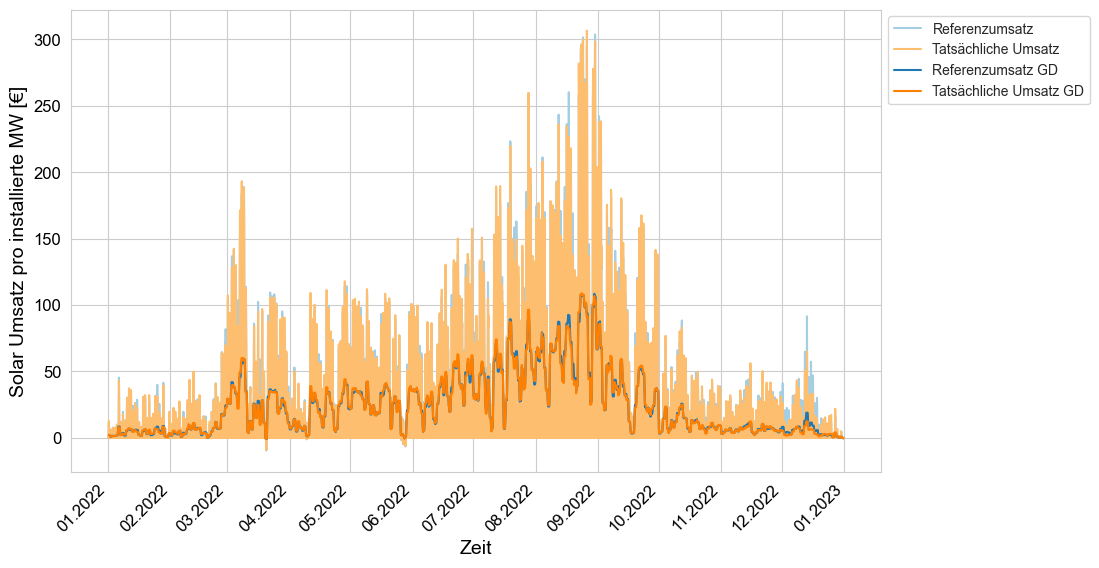

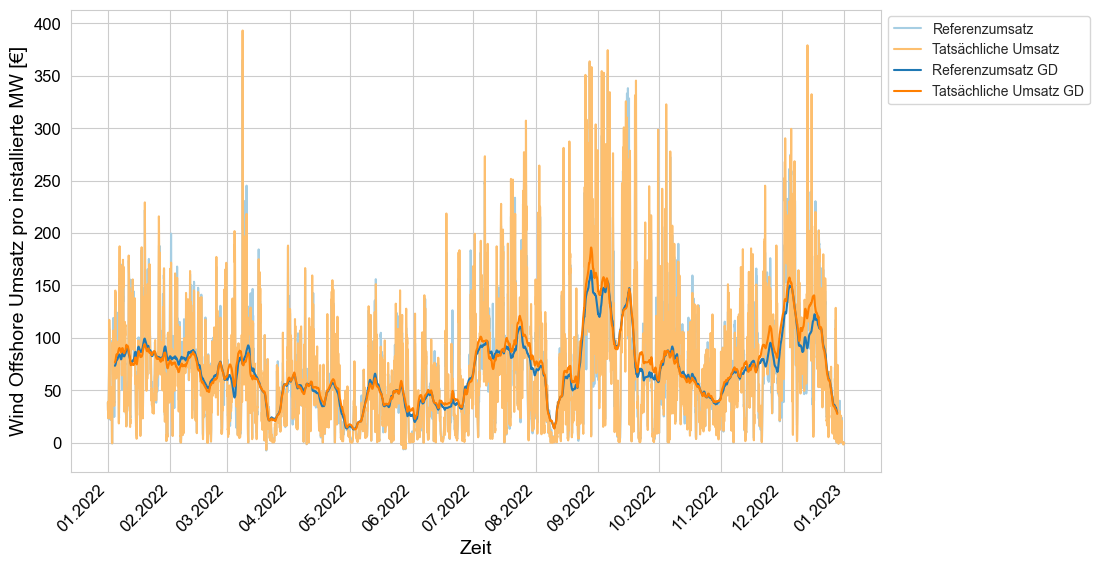

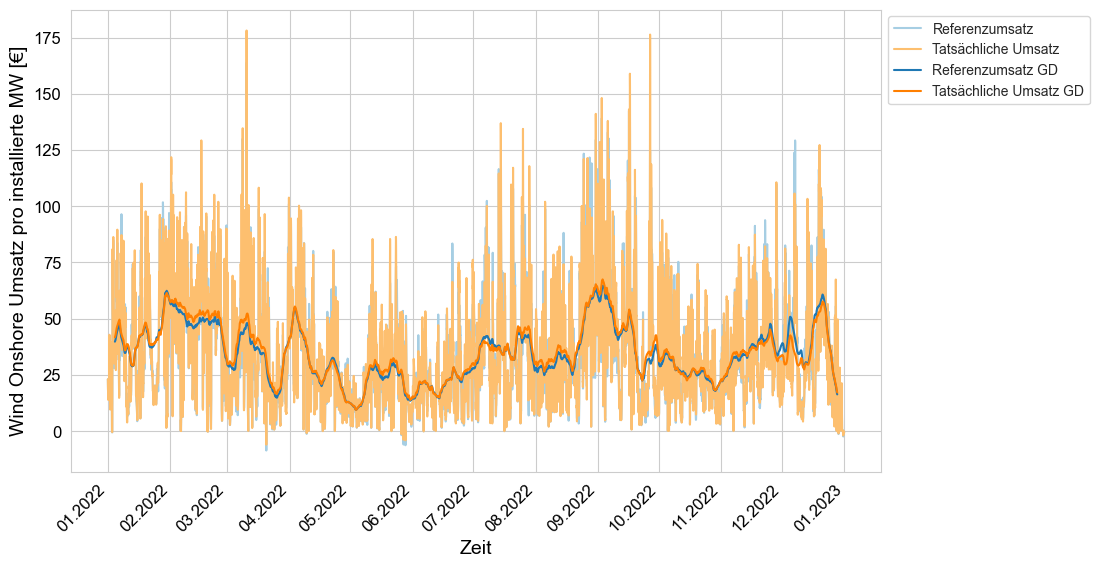

In [45]:
sns.set_style("whitegrid")
colors = sns.color_palette("Paired",8)
font_ax = {'family': 'arial',
        'color':  'black',
        'weight': 'normal',
        'size': 14,}

for rev,res in zip(rev_cols,res_cols):
    plt.figure(figsize=(12, 6))
    plt.plot(df_forec_revenue[rev + ' per MW'], label ='Referenzumsatz', color = colors[0])
    plt.plot(df_actual_revenue[rev + ' per MW'], label ='Tatsächliche Umsatz',color =colors[6])
    plt.plot(df_forec_revenue[rev + ' per MW moving avg.'], label ='Referenzumsatz GD',color = colors[1])
    plt.plot(df_actual_revenue[rev + ' per MW moving avg.'], label ='Tatsächliche Umsatz GD',color = colors[7])
    
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m.%Y'))
    plt.xticks(rotation=45, ha='right', color = 'black', fontsize = 12)
    plt.yticks(color = 'black', fontsize = 12)
    plt.xlabel('Zeit', fontdict=font_ax)
    plt.ylabel(res + ' Umsatz pro installierte MW [€]', fontdict=font_ax)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.subplots_adjust(right=0.8)



### Calculate margins from CfD derivative

In [46]:
#Aggregate Referece revenue

ref_rev = pd.DataFrame(columns=['Referenzumsatz'], index=res_cols) 
for res in res_cols:
    ref_rev.at[res,ref_rev.columns[0]] = df_forec_revenue[res + ' revenue'].sum()
#Aggregate actual revenue

act_rev = pd.DataFrame(columns=['Tatsächliche Umsatz'], index=res_cols) 
for res in res_cols:
    act_rev.at[res,act_rev.columns[0]] = df_actual_revenue[res + ' revenue'].sum()
#Aditional margin from CfD in Mio. EUR

add_margin_cfd = pd.DataFrame(columns=['CfD Marge'], index=res_cols)

for res in res_cols:
    add_margin_cfd.at[res,add_margin_cfd.columns[0]] = act_rev.loc[res].iloc[0] - ref_rev.loc[res].iloc[0]

In [47]:
add_margin_cfd

,CfD Marge
Solar,-48338980.9275
Wind Offshore,169755735.765001
Wind Onshore,371539480.555002


#### Investment costs and annuitization for reference govt. payment

### TODO Talk about context in financial terms

In [52]:
#Investment costs in EUR per MW
inv_cost = pd.DataFrame(columns=['Investitionkosten'], index=res_cols, data=[700000, 3200000, 1400000]) #TODO cite source

#annuity costs and hourly payments

payments  = pd.DataFrame(columns=['Annuity'], index=res_cols)

annual_interest_rate = 0.047 #TODO check the real value of interest rates and lifetimes for each tech
loan_lifetime_years = 25
monthly_interest_rate = annual_interest_rate / 12
total_payments = loan_lifetime_years * 12

for res in res_cols:
    payments.at[res,payments.columns[0]] = inv_cost.at[res,inv_cost.columns[0]] * (monthly_interest_rate * (1 + monthly_interest_rate)**total_payments) / ((1 + monthly_interest_rate)**total_payments - 1)

#Stochastically define the margin of the auction to be added to the investment costs
m = np.random.normal(5,1)


In [54]:
#hourly government payments to RES producers

payments['hourly payments per MW'] = payments['Annuity']*12/(365*24)*(1+(m/100))
payments

,Annuity,hourly payments per MW
Solar,3970.71691,5.703432
Wind Offshore,18151.848732,26.07283
Wind Onshore,7941.43382,11.406863


#### Final revenue calculations 

In [56]:
#structure data in a Dataframe for each RES

solar, wind_onshore, wind_offshore = [pd.DataFrame(columns=(['actual revenue', 'reference revenue','margin','govt. income', 'net income']), index=df_actual_revenue.index) for _ in range(3)]
res_list = [solar, wind_offshore, wind_onshore]

for res1, res2 in zip(res_list,res_cols):
    res1['actual revenue'] = df_actual_revenue[res2 + ' revenue per MW']
    res1['reference revenue'] = df_forec_revenue[res2 + ' revenue per MW']
    res1['margin'] = res1['actual revenue'] - res1['reference revenue']
    res1['govt. income'] = payments.loc[res2]['hourly payments per MW']
    res1['net income'] = res1['govt. income'] + res1['margin']

#Aggregate for the year

df_final_revenues = pd.DataFrame(columns=solar.columns, index=res_cols)

for row, res in zip(res_cols,res_list):
    for col in df_final_revenues.columns:
        df_final_revenues.at[row,col] = round(res[col].sum(), 2)
        
df_final_revenues

,actual revenue,reference revenue,margin,govt. income,net income
Solar,214522.92,215356.32,-833.4,49962.06,49128.66
Wind Offshore,618099.35,596299.46,21799.89,228397.99,250197.88
Wind Onshore,306350.22,299650.5,6699.72,99924.12,106623.84


#### Steel industry subsidies calculation #TODO provide more context

In [73]:
#Define dataframe with real prices and daily average prices
df_preis_day = df_preis.groupby(df_preis.index.date).mean()
df_preis_day.rename(columns = {'price':'price_avg'}, inplace=True)


TypeError: agg function failed [how->mean,dtype->object]

In [61]:
df_preis['date'] = df_preis.index.date

In [74]:
df_preis_full = df_preis.join(df_preis_day.rename(columns = {'price':'price_avg'}), on = 'date')

In [75]:
df_preis_full

,price,date,price_avg
2022-01-01 00:00:00+01:00,50.05,2022-01-01,82.578333
2022-01-01 01:00:00+01:00,41.33,2022-01-01,82.578333
2022-01-01 02:00:00+01:00,43.22,2022-01-01,82.578333
2022-01-01 03:00:00+01:00,45.46,2022-01-01,82.578333
2022-01-01 04:00:00+01:00,37.67,2022-01-01,82.578333
...,...,...,...
2022-12-31 19:00:00+01:00,-1.01,2022-12-31,-0.792083
2022-12-31 20:00:00+01:00,-1.39,2022-12-31,-0.792083
2022-12-31 21:00:00+01:00,-1.04,2022-12-31,-0.792083
2022-12-31 22:00:00+01:00,-1.07,2022-12-31,-0.792083


In [79]:
#Establish a daily maximum value, the so called "Brückenstrompreis"

df_preis_full.loc[df_preis_full['price'] < df_preis_full['price_avg'],'subsidized price'] = df_preis_full['price']
df_preis_full.loc[df_preis_full['price'] >= df_preis_full['price_avg'],'subsidized price'] = df_preis_full['price_avg']


,price,date,price_avg,subsidized price
2022-01-01 00:00:00+01:00,50.05,2022-01-01,82.578333,50.050000
2022-01-01 01:00:00+01:00,41.33,2022-01-01,82.578333,41.330000
2022-01-01 02:00:00+01:00,43.22,2022-01-01,82.578333,43.220000
2022-01-01 03:00:00+01:00,45.46,2022-01-01,82.578333,45.460000
2022-01-01 04:00:00+01:00,37.67,2022-01-01,82.578333,37.670000
...,...,...,...,...
2022-12-31 19:00:00+01:00,-1.01,2022-12-31,-0.792083,-1.010000
2022-12-31 20:00:00+01:00,-1.39,2022-12-31,-0.792083,-1.390000
2022-12-31 21:00:00+01:00,-1.04,2022-12-31,-0.792083,-1.040000
2022-12-31 22:00:00+01:00,-1.07,2022-12-31,-0.792083,-1.070000


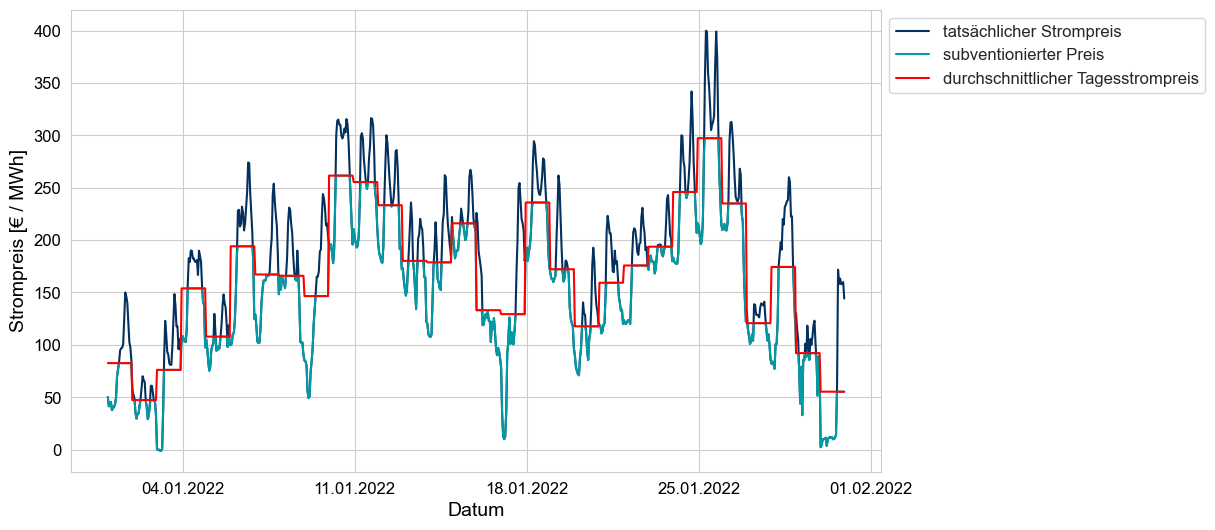

In [80]:
#Visualize capped price for january

sns.set_style("whitegrid")
colors = ['#03305D', '#009BA4']
font_ax = {'family': 'arial',
           'color':  'black',
           'weight': 'normal',
           'size': 14,}


hours = 24*30
plt.figure(figsize=(12, 6))
plt.plot(df_preis_full.head(hours).index,df_preis_full.head(hours)['price'], label= 'tatsächlicher Strompreis', color = colors[0])
plt.plot(df_preis_full.head(hours).index,df_preis_full.head(hours)['subsidized price'], label = 'subventionierter Preis', color=colors[1])
plt.plot(df_preis_full.head(hours).index,df_preis_full.head(hours)['price_avg'], label= 'durchschnittlicher Tagesstrompreis', color = 'red')

plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d.%m.%Y'))
plt.xticks(ha='center', color = 'black', fontsize = 12)
plt.yticks(color = 'black', fontsize = 12)
plt.xlabel('Datum', fontdict=font_ax)
plt.ylabel('Strompreis [€ / MWh]', fontdict=font_ax)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize = 12)

plt.subplots_adjust(right=0.8)



In [81]:
#Energy consumption based on production #TODO extend explanation and assumptions
tot_prod = 36.8*1e6
energy_cons_pro_ton = 625 #energy consumption per produced steel ton [kWh]
tot_energy = tot_prod * energy_cons_pro_ton/1000 #[MWh]
hourly_demand = tot_energy/(365*24)

In [83]:
df_steel = pd.DataFrame(columns=['actual price', 'subsidized price', 'demand_steel_prod'], index=df_preis_full.index)
df_steel['actual price'] = df_preis_full['price']
df_steel['subsidized price'] = df_preis_full['subsidized price']
df_steel['demand_steel_prod'] = hourly_demand
df_steel['real cost'] = df_steel['demand_steel_prod'] * df_steel['actual price']
df_steel['subsidized cost'] = df_steel['demand_steel_prod'] * df_steel['subsidized price']


In [84]:
#Aggregate for the year
df_steel_agg = pd.DataFrame(index=df_steel.columns[-3:], columns=['Value'])
for row in df_steel_agg.index:
    df_steel_agg.at[row, df_steel_agg.columns[0]] = round(df_steel[row].sum(), 2)
df_steel_agg

,Value
demand_steel_prod,23000000.0
real cost,5415261281.96
subsidized cost,4867298860.0


In [91]:
steel_subsidy = df_steel_agg.loc['real cost'].iloc[0] - df_steel_agg.loc['subsidized cost'].iloc[0]
steel_subsidy

547962421.96

In [92]:
#TODO Explain the concept of disjunkt investment
df_subs_through_res = pd.DataFrame(index=res_cols, columns=['Number of required MW', 'percentage of inst_cap'])

for rev,res in zip(res_list,res_cols):
    df_subs_through_res.at[res,df_subs_through_res.columns[0]] = round(steel_subsidy/rev['actual revenue'].sum())
    df_subs_through_res.at[res,df_subs_through_res.columns[1]] = df_subs_through_res.at[res,df_subs_through_res.columns[0]] / inst_cap[res].iloc[0]
    
df_subs_through_res
    

,Number of required MW,percentage of inst_cap
Solar,2554,0.044033
Wind Offshore,887,0.113908
Wind Onshore,1789,0.03226


In [93]:
df_subs_through_res = pd.DataFrame(index=res_cols, columns=['Disjunkte Investition [MW]'])

for rev,res in zip(res_list,res_cols):
    df_subs_through_res.at[res,df_subs_through_res.columns[0]] = round(steel_subsidy/(rev['actual revenue'].sum()-rev['govt. income'].sum()))

df_subs_through_res


,Disjunkte Investition [MW]
Solar,3330
Wind Offshore,1406
Wind Onshore,2655
